In [19]:
%load_ext autoreload
%autoreload 2
import tifffile as tif
import matplotlib.pyplot as plt
import numpy as np
import carreno.processing.patches as patches

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Patchify example
For the sake of my RAM, we divide volumes in patches

(90, 90, 3) float64


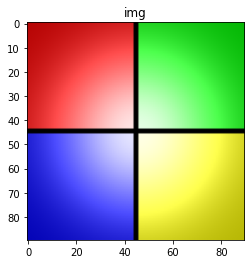

In [15]:
def makeGaussian(size, fwhm = 3, center=None):
    # https://stackoverflow.com/questions/7687679/how-to-generate-2d-gaussian-with-python
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)


def windows_logo(size):
    # was bored sorry
    half = size // 2
    windows_logo = np.zeros((size, size, 3))
    windows_logo[:half, :half,  0] = 0.7
    windows_logo[:half,  half:, 1] = 0.7
    windows_logo[ half:,:half,  2] = 0.7
    windows_logo[ half:, half:,:2] = 0.7
    light = makeGaussian(size, size * 0.6) * 0.9
    windows_logo = np.clip(windows_logo + np.stack([light]*3, axis=2), 0, 1)
    sep = max(1, size * 0.01)
    windows_logo[half-sep:half+sep, :] = 0
    windows_logo[:, half-sep:half+sep] = 0
    # now add distortion lol
    return windows_logo

img = windows_logo(90)
    
print(img.shape, img.dtype)
plt.imshow(img)
plt.title("img")
plt.show()

(120, 120, 3)
patch shape (3, 3, 1, 40, 40, 3)
order : (3, 3, 1)
nb of patches : 9


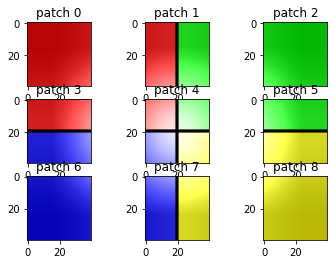

In [33]:
patch_shape = (40, 40, 3)
stride = (30, 30, 3)

#
# patchify
#
patch = patches.patchify(img, patch_shape, stride, 0)
print("patch shape", patch.shape)
order = patch.shape[:3]
print("order :", order)
patch = patch.reshape([np.prod(order)] + list(patch.shape[3:]))
print("nb of patches :", len(patch))

for i in range(len(patch)):
    plt.subplot(3,3,i+1)
    plt.imshow(patch[i])
    plt.title("patch " + str(i))
plt.show()

AttributeError: 'list' object has no attribute 'shape'

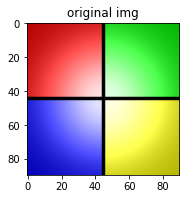

In [7]:
#
# unpatchify
#
plt.subplot(121)
plt.imshow(img)
plt.title('original img')
    
# note that shape might difer from the original because of patch shape
unpatch = unpatchify(patch, order, stride)
print("previous shape :", img.shape)
print("new shape :", unpatch.shape)
    
plt.subplot(122)
plt.imshow(unpatch)
plt.title('unpatchified img')  # nice verb
    
plt.show()